In [1]:
import os
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import pandas as pd
import xarray as xr
import tensorflow as tf
import wandb 

from coldpooling.cp_detection_timeseries import cp_detection as cpdt


from coldpooling.data_loader import load_datasets,load_and_average_dataset, find_cps, sample_indices_3sets, create_windows
from coldpooling.model import compile_and_fit,define_models,get_model,plot_variable_importance,plot_model_performance,plot_loss

plt.rcParams.update({'font.size': 15})


2024-03-18 09:59:55.598724: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
IN_WIDTH=12
OUT_STEPS=6
SHIFT=2


In [3]:
fp='datasets/'
file1min = fp+'station_output.nc'
fileAveraged = fp+'WRF-10min.csv'
ds1min, dfAveraged = load_datasets(file1min,fileAveraged)
ds1min, dfAveraged = load_datasets(file1min,fileAveraged)

#ds1min, dfAveraged = load_and_average_dataset(file1min,averaging_interval='10min')

dfAveraged

,T2__Pout,RAIN_1MIN__Pout,Q2__Pout,SMOIS__Pout,U10__Pout,V10__Pout,PSFC__Pout,lat__Pout,lon__Pout,T2__Dakar,RAIN_1MIN__Dakar,Q2__Dakar,SMOIS__Dakar,U10__Dakar,V10__Dakar,PSFC__Dakar,lat__Dakar,lon__Dakar
Time,,,,,,,,,,,,,,,,,,
2019-07-01 00:00:00,304.21515,0.0,0.014849,0.029992,4.705212,-1.984947,100629.140,14.761833,-17.06885,300.69144,0.0,0.014969,0.03,3.235204,-1.452492,100681.180,14.725876,-17.468525
2019-07-01 00:10:00,304.14072,0.0,0.014877,0.029992,4.699885,-2.037614,100641.110,14.761833,-17.06885,300.67047,0.0,0.014975,0.03,3.246232,-1.347251,100690.920,14.725876,-17.468525
2019-07-01 00:20:00,304.07465,0.0,0.014900,0.029992,4.724223,-2.055382,100654.390,14.761833,-17.06885,300.65024,0.0,0.014993,0.03,3.246986,-1.214879,100703.940,14.725876,-17.468525
2019-07-01 00:30:00,303.99664,0.0,0.014921,0.029992,4.620109,-2.016595,100668.800,14.761833,-17.06885,300.60248,0.0,0.015018,0.03,3.031911,-1.138263,100721.164,14.725876,-17.468525
2019-07-01 00:40:00,303.88025,0.0,0.014943,0.029992,4.520135,-2.152279,100681.360,14.761833,-17.06885,300.57977,0.0,0.015058,0.03,2.954337,-1.286393,100729.240,14.725876,-17.468525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-31 23:20:00,309.47910,0.0,0.004264,0.030425,-3.135566,0.394919,100434.330,14.761833,-17.06885,303.25150,0.0,0.017928,0.03,2.458823,1.832447,100475.580,14.725876,-17.468525
2019-10-31 23:30:00,309.50348,0.0,0.004338,0.030425,-2.929377,0.104352,100439.625,14.761833,-17.06885,303.14850,0.0,0.017928,0.03,2.349032,1.779581,100493.280,14.725876,-17.468525
2019-10-31 23:40:00,309.51535,0.0,0.004396,0.030425,-2.902574,-0.495850,100440.170,14.761833,-17.06885,303.23770,0.0,0.017676,0.03,2.235510,1.787299,100505.445,14.725876,-17.468525


In [4]:
time_indices_split,Propagating_CPs_set, Not_propagating_CPs_set, Not_CPs_set=sample_indices_3sets(ds1min, dfAveraged, n_samples_beforeafterCPs=12)
len(time_indices_split['train'])

980

In [5]:
dfAveraged["WS__Dakar"]=np.sqrt(dfAveraged["U10__Dakar"]**2 + dfAveraged["V10__Dakar"]**2)
dfAveraged["WS__Pout"]=np.sqrt(dfAveraged["U10__Pout"]**2 + dfAveraged["V10__Pout"]**2)

all_input_columns=["T2__Dakar", "Q2__Dakar", "WS__Dakar", "PSFC__Dakar","T2__Pout","Q2__Pout", "WS__Pout", "PSFC__Pout"]

windows, num_features = create_windows(station_input= 'dakar_and_pout',#'dakar_and_pout',
                                       all_data=dfAveraged,
                                       time_indices=time_indices_split,
                                       input_columns = all_input_columns,
                                       IN_WIDTH=IN_WIDTH,
                                       OUT_STEPS=OUT_STEPS,
                                       SHIFT=SHIFT)

for example_inputs, example_labels in windows.train.take(1):
    print(f"Inputs shape (batch, time, features): {example_inputs.shape}")
    print(f"Labels shape (batch, time, features): {example_labels.shape}")

    
    
#windows.plot(ymin=290,ymax=305)




num_features

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2024-03-18 10:00:07.760996: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-03-18 10:00:07.761028: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Inputs shape (batch, time, features): (64, 12, 8)
Labels shape (batch, time, features): (64, 6, 1)


8

T2__Pout               300.552461
RAIN_1MIN__Pout          0.001955
Q2__Pout                 0.017334
SMOIS__Pout              0.030100
U10__Pout                1.997677
V10__Pout               -0.512824
PSFC__Pout          100723.672719
lat__Pout               14.761833
lon__Pout              -17.068850
T2__Dakar              300.496510
RAIN_1MIN__Dakar         0.000957
Q2__Dakar                0.017582
SMOIS__Dakar             0.030000
U10__Dakar               2.052963
V10__Dakar              -0.738669
PSFC__Dakar         100734.182245
lat__Dakar              14.725876
lon__Dakar             -17.468525
WS__Dakar                3.615979
WS__Pout                 3.538917
dtype: float64
T2__Pout            2.855252e+00
RAIN_1MIN__Pout     2.824798e-02
Q2__Pout            2.131942e-03
SMOIS__Pout         1.759508e-04
U10__Pout           2.147294e+00
V10__Pout           2.499772e+00
PSFC__Pout          1.653231e+02
lat__Pout           0.000000e+00
lon__Pout           0.000000e+00
T2__Daka

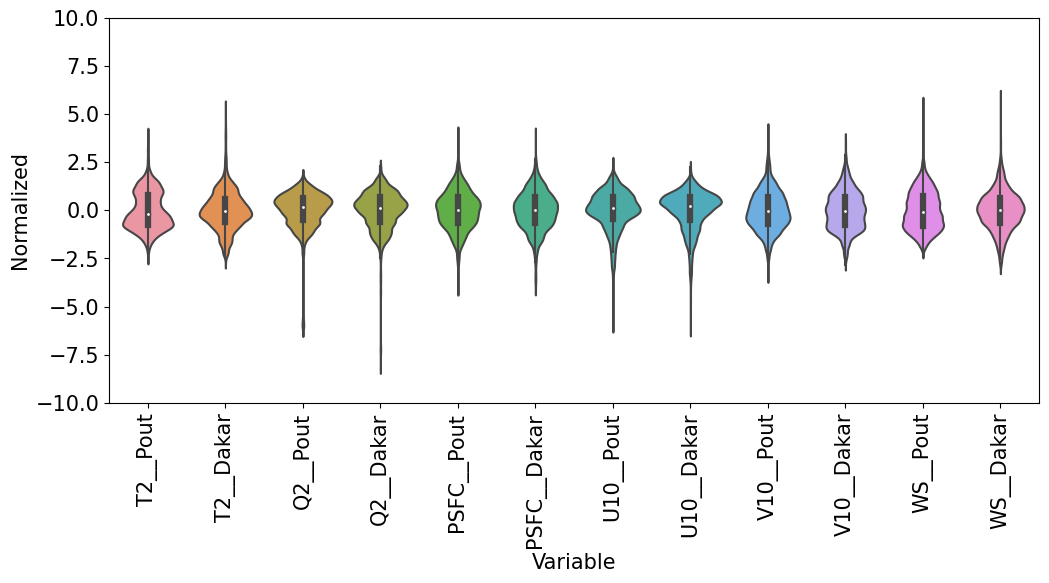

In [6]:
import seaborn as sns

mean_all_data = dfAveraged.mean()
std_all_data = dfAveraged.std()

df_all = (dfAveraged - mean_all_data) / std_all_data
df_std = (dfAveraged - mean_all_data) / std_all_data
columns=[ "T2__Pout","T2__Dakar","Q2__Pout","Q2__Dakar","PSFC__Pout","PSFC__Dakar","U10__Pout","U10__Dakar","V10__Pout","V10__Dakar","WS__Pout","WS__Dakar"]
df_std = df_std[columns].melt(var_name="Column", value_name="Normalized")
plt.figure(figsize=(12, 5),dpi=100)
ax = sns.violinplot(x="Column", y="Normalized", data=df_std)
ax.set_xlabel('Variable')
_ = ax.set_xticklabels(dfAveraged[columns].keys(), rotation=90)
_ = ax.set_ylim(-10,10)

print(mean_all_data)
print(std_all_data)

In [7]:
# Call the function to define models
define_models(OUT_STEPS, num_features, lstm_units=200)




In [8]:
ARlstm=get_model('AR lstm')
lstm=get_model('lstm')


In [9]:
historyARlstm=compile_and_fit(ARlstm,windows)
historylstm=compile_and_fit(lstm,windows)


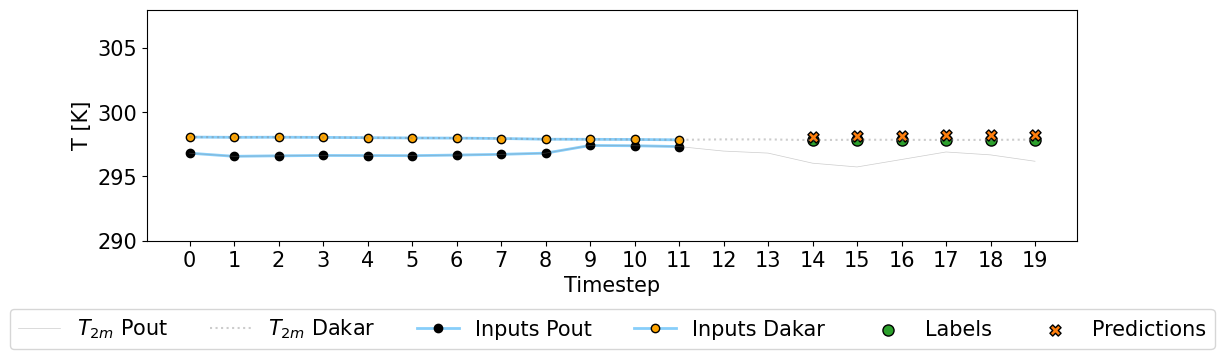

In [10]:
windows.plot(ARlstm, ymin=290, ymax=308, max_subplots=1)



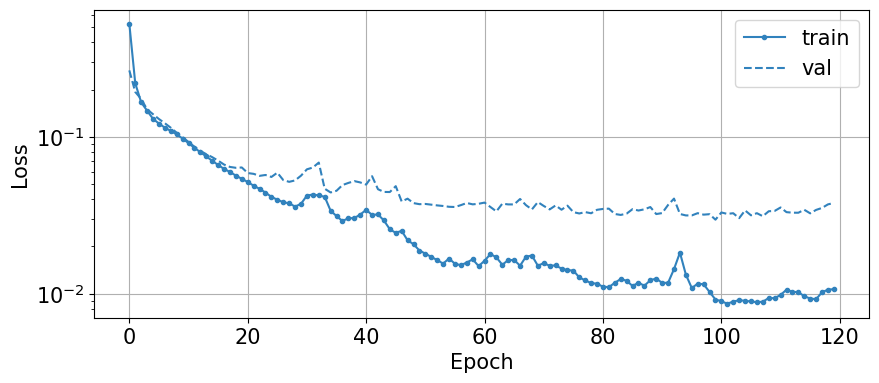

In [11]:
plot_loss(historyARlstm)

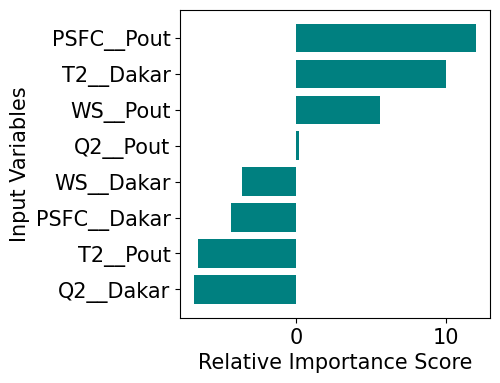

In [12]:

plot_variable_importance(ARlstm,windows)

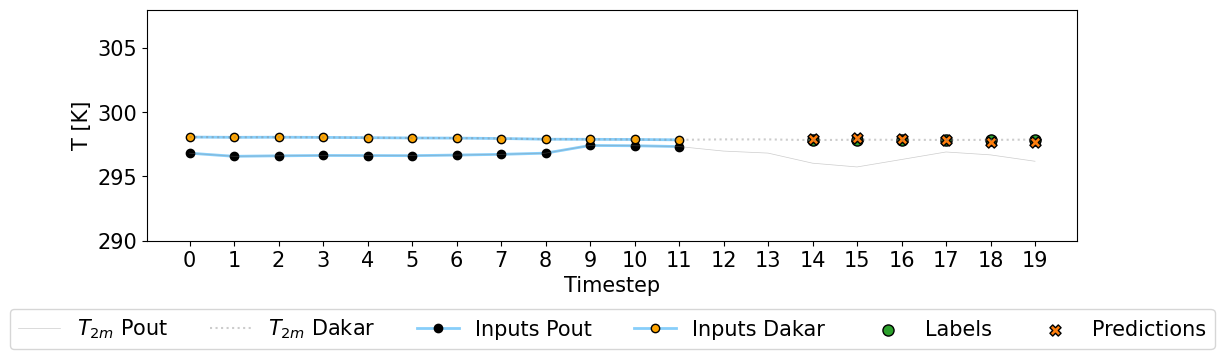

In [13]:
windows.plot(lstm, ymin=290, ymax=308, max_subplots=1)


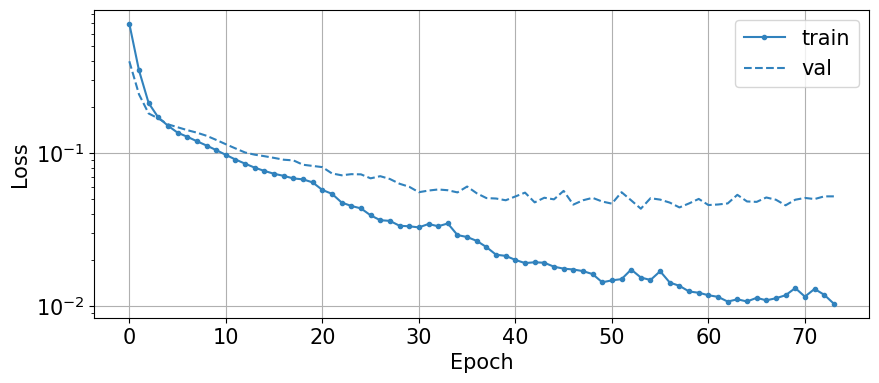

In [14]:
plot_loss(historylstm)

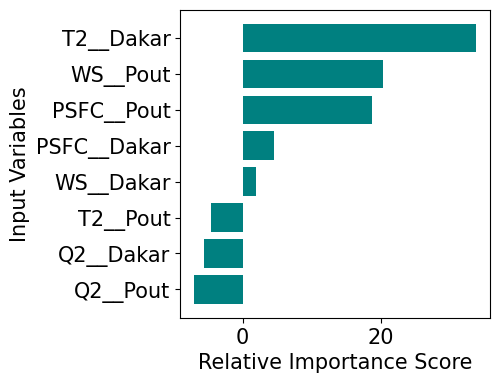

In [15]:

plot_variable_importance(lstm,windows)

In [16]:
val_performance={}
test_performance={}
val_performance['One shot'] = lstm.evaluate(windows.val)
test_performance['One shot'] = lstm.evaluate(windows.test)

val_performance['Auto-regressive'] = ARlstm.evaluate(windows.val)
test_performance['Auto-regressive'] = ARlstm.evaluate(windows.test)

#performance[model.name] = model.evaluate(window.test, verboARlstm.evaluate(windows.val)se=0)

3/3 [==============================] - 0s 6ms/step - loss: 0.0426 - mean_absolute_error: 0.1306


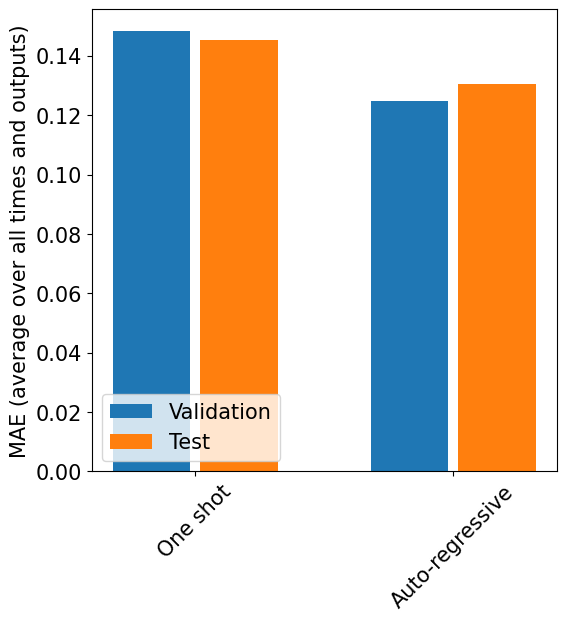

In [17]:
plt.figure(figsize=(6,6),dpi=100)
x = np.arange(len(val_performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in test_performance.values()]
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=val_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend(loc='lower left')

In [18]:

prediction_steps=0

cps_dakar=find_cps(ds1min, dfAveraged, 'Dakar')
cps_pout=find_cps(ds1min, dfAveraged, 'Pout')
len(cps_dakar),len(cps_pout)


(14, 42)

In [19]:
#test_cps_propagating = list(set(time_indices_split['test']).intersection(Propagating_CPs_set))
test_cps_propagating = list(set(time_indices_split['val']).intersection(cps_dakar))
propagating=dict(train=[], val=[], test=np.array(test_cps_propagating)-IN_WIDTH-SHIFT-prediction_steps)       
windows_propagating,num_features=create_windows(station_input='dakar_and_pout',
                                           all_data=dfAveraged,
                                           time_indices=propagating,
                                           input_columns = all_input_columns,
                                           IN_WIDTH=IN_WIDTH,
                                           OUT_STEPS=OUT_STEPS,
                                           SHIFT=SHIFT)
#test_cps_not_propagating = list(set(time_indices_split['test']).intersection(Not_propagating_CPs_set))
test_cps_not_propagating = list(set(time_indices_split['val']).intersection(set(cps_pout)).difference(Propagating_CPs_set))
not_propagating=dict(train=[], val=[], test=np.array(test_cps_not_propagating)-IN_WIDTH+1-prediction_steps)       
windows_not_propagating,num_features=create_windows(station_input='dakar_and_pout',
                                           all_data=dfAveraged,
                                           time_indices=not_propagating,
                                           input_columns = all_input_columns,
                                           IN_WIDTH=IN_WIDTH,
                                           OUT_STEPS=OUT_STEPS,
                                           SHIFT=SHIFT)



test_no_cps = list(set(time_indices_split['val']).intersection(Not_CPs_set))
no_cps=dict(train=[], val=[], test=np.array(test_no_cps)-IN_WIDTH-SHIFT-prediction_steps)       
windows_no_cps,num_features=create_windows(station_input='dakar_and_pout',
                                           all_data=dfAveraged,
                                           time_indices=no_cps,
                                           input_columns = all_input_columns,
                                           IN_WIDTH=IN_WIDTH,
                                           OUT_STEPS=OUT_STEPS,
                                           SHIFT=SHIFT)

'''
TEST_CASES = dict(
    cps_propagating=dict(filter_function=lambda idxs: set(idxs).difference(...), foobar=24),
    cps_not_propagating=dict(filter_function=lambda idxs: idxs, foobar=1),
)

OUTPUT = {}

for usecase, values in USE_CASES.items():
    print(usecase)
    idxs = usecase["filter_function"](idxs)
    foobar = usecase['foobar']
    
'''



'\nTEST_CASES = dict(\n    cps_propagating=dict(filter_function=lambda idxs: set(idxs).difference(...), foobar=24),\n    cps_not_propagating=dict(filter_function=lambda idxs: idxs, foobar=1),\n)\n\nOUTPUT = {}\n\nfor usecase, values in USE_CASES.items():\n    print(usecase)\n    idxs = usecase["filter_function"](idxs)\n    foobar = usecase[\'foobar\']\n    \n'

In [20]:
test_cps_propagating

[3833, 11596, 15783]

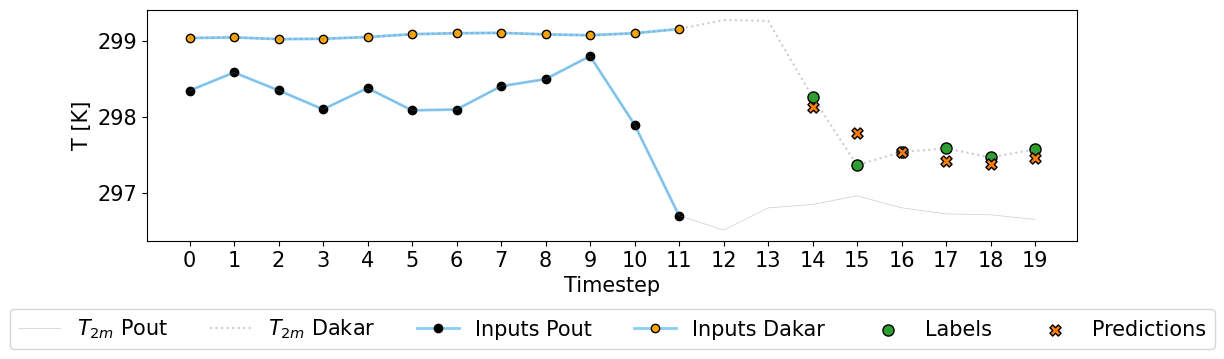

In [21]:
if test_cps_propagating:
    windows_propagating.plot(lstm, ylims=False,ymin=296,ymax=300,plot_col_input='T2__Dakar',max_subplots=1)
else:
    print('Whoops no intersecting subset for propagating CPs')

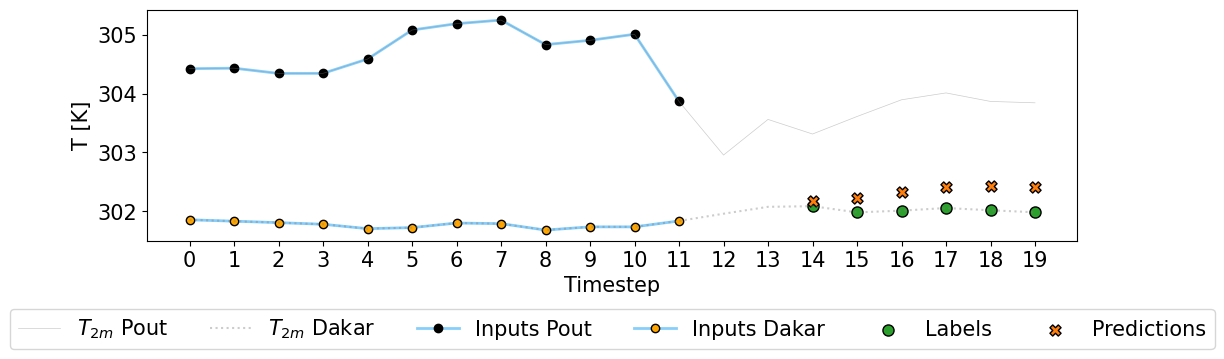

In [22]:
if test_cps_not_propagating:
    windows_not_propagating.plot(lstm, ylims=False,ymin=298,ymax=307,plot_col_input='T2__Dakar',max_subplots=1)
else: 
    print('Whoops no intersecting subset for not-propagating CPs')

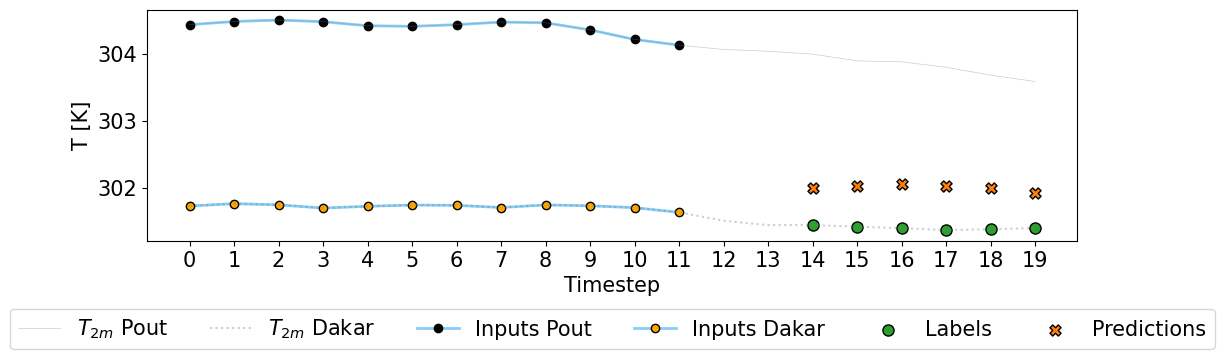

In [23]:
windows_no_cps.plot(lstm, ylims=False,ymin=294,ymax=308,plot_col_input='T2__Dakar',max_subplots=1)

In [24]:
test_cps_propagating = list(set(time_indices_split['test']).intersection(Propagating_CPs_set))
#test_cps_propagating = list(set(time_indices_split['test']).intersection(cps_dakar))
propagating=dict(train=[], val=[], test=np.array(test_cps_propagating)-IN_WIDTH-SHIFT-prediction_steps)       
windows_propagating,num_features=create_windows(station_input='dakar_and_pout',
                                           all_data=dfAveraged,
                                           time_indices=propagating,
                                           input_columns = all_input_columns,
                                           IN_WIDTH=IN_WIDTH,
                                           OUT_STEPS=OUT_STEPS,
                                           SHIFT=SHIFT)
test_cps_not_propagating = list(set(time_indices_split['test']).intersection(Not_propagating_CPs_set))
#test_cps_not_propagating = list(set(time_indices_split['test']).intersection(set(cps_pout)).difference(Propagating_CPs_set))
not_propagating=dict(train=[], val=[], test=np.array(test_cps_not_propagating)-IN_WIDTH+SHIFT-prediction_steps)       
windows_not_propagating,num_features=create_windows(station_input='dakar_and_pout',
                                           all_data=dfAveraged,
                                           time_indices=not_propagating,
                                           input_columns = all_input_columns,
                                           IN_WIDTH=IN_WIDTH,
                                           OUT_STEPS=OUT_STEPS,
                                           SHIFT=SHIFT)



test_no_cps = list(set(time_indices_split['test']).intersection(Not_CPs_set))
no_cps=dict(train=[], val=[], test=np.array(test_no_cps)-IN_WIDTH-SHIFT-prediction_steps)       
windows_no_cps,num_features=create_windows(station_input='dakar_and_pout',
                                           all_data=dfAveraged,
                                           time_indices=no_cps,
                                           input_columns = all_input_columns,
                                           IN_WIDTH=IN_WIDTH,
                                           OUT_STEPS=OUT_STEPS,
                                           SHIFT=SHIFT)


1/1 [==============================] - 0s 55ms/step - loss: 0.0838 - mean_absolute_error: 0.2091


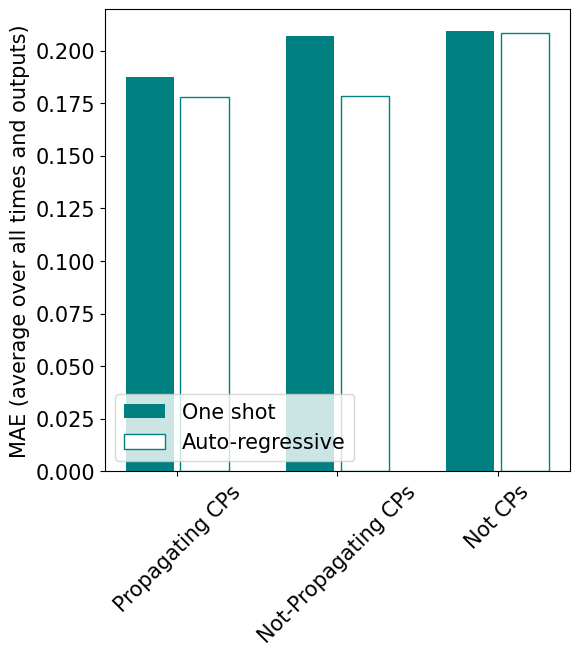

In [46]:
performance={}
performancelstm={}
performance["Propagating CPs"] = ARlstm.evaluate(windows_propagating.test)

performance["Not-Propagating CPs"] = ARlstm.evaluate(windows_not_propagating.test)

performance["Not CPs"] = ARlstm.evaluate(windows_no_cps.test)

performancelstm["Propagating CPs"] = lstm.evaluate(windows_propagating.test)

performancelstm["Not-Propagating CPs"] = lstm.evaluate(windows_not_propagating.test)

performancelstm["Not CPs"] = lstm.evaluate(windows_no_cps.test)

plt.figure(figsize=(6,6),dpi=100)
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm.metrics_names.index('mean_absolute_error')
testlstm = [v[metric_index] for v in performancelstm.values()]
test = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, testlstm, width, label='One shot', color='teal')
plt.bar(x + 0.17, test, width, label='Auto-regressive', edgecolor='teal',color='white')
plt.xticks(ticks=x,labels=performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend(loc='lower left')

In [26]:
start_date = "2023-09-22"
end_date_atmos = "2023-10-11"
end_date = "2023-10-10"

In [27]:
fp_dakar = "./../Dakar_atmos41.csv"
ds_dakar = pd.read_csv(fp_dakar, parse_dates=["Timestamp"], index_col="Timestamp")
ds_dakar = ds_dakar.loc[start_date:end_date]
ds_dakar.head(-1)

fp_pout = "./../Pout_Davis.csv"
ds_pout = pd.read_csv(fp_pout, skiprows=5, encoding="latin1",parse_dates=["Date & Time"], index_col="Date & Time", low_memory=False)
ds_pout.index.name = "Timestamp"
ds_pout = ds_pout.loc[start_date:end_date]
ds_pout = ds_pout.apply(pd.to_numeric, errors='coerce')
ds_pout.head(-1)
                        
index_set_df1 = set(ds_pout.index)
index_set_df2 = set(ds_dakar.index)

# Find timestamps present in df1 but not in df2
timestamps_only_in_df1 = index_set_df1 - index_set_df2

# Find timestamps present in df2 but not in df1
timestamps_only_in_df2 = index_set_df2 - index_set_df1

# Print the results
# Print the results
print("Timestamps only in DataFrame 1:", len(timestamps_only_in_df1))
print("Timestamps only in DataFrame 2:", len(timestamps_only_in_df2))

ds_pout_reindexed = ds_pout.reindex(ds_dakar.index)
ds_pout_reindexed
ds_combined =  pd.DataFrame(columns=all_input_columns, index=ds_dakar.index)

def spec_hum_from_vapor_press(vapor_press, press):
    eps = 0.622
    q = (vapor_press)*eps / (press - (1-eps)*vapor_press)
    return q
def spec_humidity_from_rel_hum(temperature_C, relative_humidity, total_pressure_hPa):
    # Convert temperature from Celsius to Kelvin
    temperature_K = temperature_C + 273.15
    
    # Calculate saturation vapor pressure (e_s) using the Clausius-Clapeyron equation
    es = 6.112 * np.exp((17.67 * temperature_C) / (temperature_C + 243.5))
    
    # Calculate vapor pressure (e) from relative humidity and saturation vapor pressure
    e = (relative_humidity / 100) * es
    
    # Calculate specific humidity (q) using the vapor pressure and total pressure
    q = (0.622 * e) / (total_pressure_hPa - (0.378 * e))
    
    return q
                        
                        
ds_combined["T2__Dakar"]=ds_dakar['19041.metergroup-atmos41-air-temperature'].values + 273.15
ds_combined["Q2__Dakar"]=spec_hum_from_vapor_press(ds_dakar['19041.metergroup-atmos41-vapor-pressure'].values,ds_dakar['19041.metergroup-atmos41-atmospheric-pressure'].values)
ds_combined["U10__Dakar"]=ds_dakar['19041.metergroup-atmos41-east-wind-speed'].values
ds_combined["V10__Dakar"]=ds_dakar['19041.metergroup-atmos41-north-wind-speed'].values
ds_combined["WS__Dakar"]= np.sqrt(ds_dakar['19041.metergroup-atmos41-north-wind-speed'].values**2 + ds_dakar['19041.metergroup-atmos41-east-wind-speed'].values**2)
ds_combined["PSFC__Dakar"]=ds_dakar['19041.metergroup-atmos41-atmospheric-pressure'].values
ds_combined["T2__Pout"]=ds_pout_reindexed['Temp - °C'].values + 273.15
ds_combined["Q2__Pout"]=spec_humidity_from_rel_hum(ds_pout_reindexed['Temp - °C'].values,ds_pout_reindexed['Hum - %'].values,ds_pout_reindexed['Barometer - hPa'].values)
ds_combined["U10__Pout"]=ds_pout_reindexed['Wind Speed - m/s'].values
ds_combined["V10__Pout"]=ds_pout_reindexed['Wind Speed - m/s'].values
ds_combined["WS__Pout"]=ds_pout_reindexed['Wind Speed - m/s'].values
ds_combined["PSFC__Pout"]=ds_pout_reindexed['Barometer - hPa'].values

                        
ds_combined_10min=ds_combined.resample('10min').mean()

len(ds_combined_10min)

Timestamps only in DataFrame 1: 0
Timestamps only in DataFrame 2: 12960


2736

In [28]:
dtdata=pd.to_datetime(ds_combined.index)
ttdata=(ds_pout_reindexed['Temp - °C'].values + 273.15)
rrdata=(ds_pout_reindexed['Rain - mm'].values)

cps_pout = cpdt(dtdata,ttdata,rrdata)  # Perform cold-pool detection
cp_times_pout    = cps_pout.datetimes()         
idx_real_cps_pout = ds_combined_10min.index.get_indexer(cp_times_pout, method='nearest')
idx_real_cps_pout

dtdata=pd.to_datetime(ds_combined.index)
ttdata=(ds_dakar['19041.metergroup-atmos41-air-temperature'].values + 273.15)
rrdata=(ds_dakar['19041.metergroup-atmos41-precipitation'].values)

cps_dakar = cpdt(dtdata,ttdata,rrdata)  # Perform cold-pool detection
cp_times_dakar    = cps_dakar.datetimes()         
idx_real_cps_dakar = ds_combined_10min.index.get_indexer(cp_times_dakar, method='nearest')
idx_real_cps_dakar


*** WARNING: Availability of TT data is below 90 % (52.6 %) ***
*** WARNING: Availability of RR data is below 90 % (52.6 %) ***


array([174])

In [29]:
time_indices_for_inference_real = dict(train=[], val=[], test=idx_real_cps_dakar-IN_WIDTH-10)

windows_real1, num_features = create_windows(station_input='dakar_and_pout',
                                       all_data=ds_combined_10min,
                                       input_columns = all_input_columns,
                                       time_indices=time_indices_for_inference_real,
                                       #df_for_normalizing=dfAveraged[ds_combined_10min.columns],
                                       IN_WIDTH=IN_WIDTH,
                                       OUT_STEPS=OUT_STEPS,
                                       SHIFT=SHIFT)
time_indices_for_inference_real = dict(train=[], val=[], test=idx_real_cps_dakar-IN_WIDTH)

windows_real2, num_features = create_windows(station_input='dakar_and_pout',
                                       all_data=ds_combined_10min,
                                       input_columns = all_input_columns,
                                       time_indices=time_indices_for_inference_real,
                                       #df_for_normalizing=dfAveraged[ds_combined_10min.columns],
                                       IN_WIDTH=IN_WIDTH,
                                       OUT_STEPS=OUT_STEPS,
                                       SHIFT=SHIFT)


time_indices_for_inference_real = dict(train=[], val=[], test=idx_real_cps_dakar-IN_WIDTH+5)

windows_real3, num_features = create_windows(station_input='dakar_and_pout',
                                       all_data=ds_combined_10min,
                                       input_columns = all_input_columns,
                                       time_indices=time_indices_for_inference_real,
                                       #df_for_normalizing=dfAveraged[ds_combined_10min.columns],      
                                       IN_WIDTH=IN_WIDTH,
                                       OUT_STEPS=OUT_STEPS,
                                       SHIFT=SHIFT)

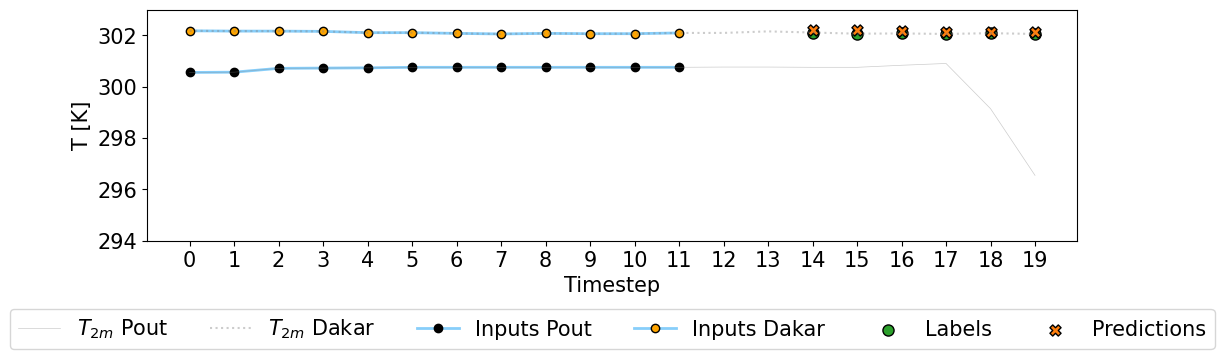

In [30]:
windows_real1.plot(ARlstm, plot_col_input='T2__Dakar', max_subplots=5, ylims=True, ymin=294, ymax=303)

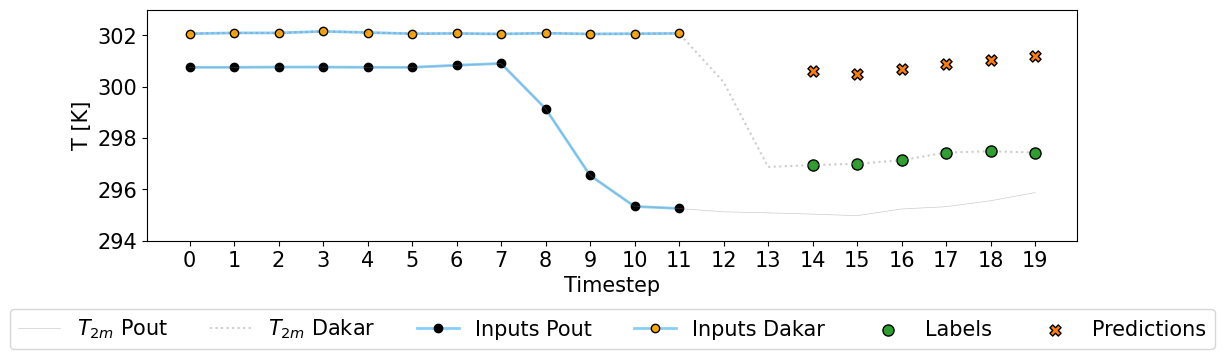

In [31]:
windows_real2.plot(ARlstm, plot_col_input='T2__Dakar', max_subplots=5, ylims=True, ymin=294, ymax=303)

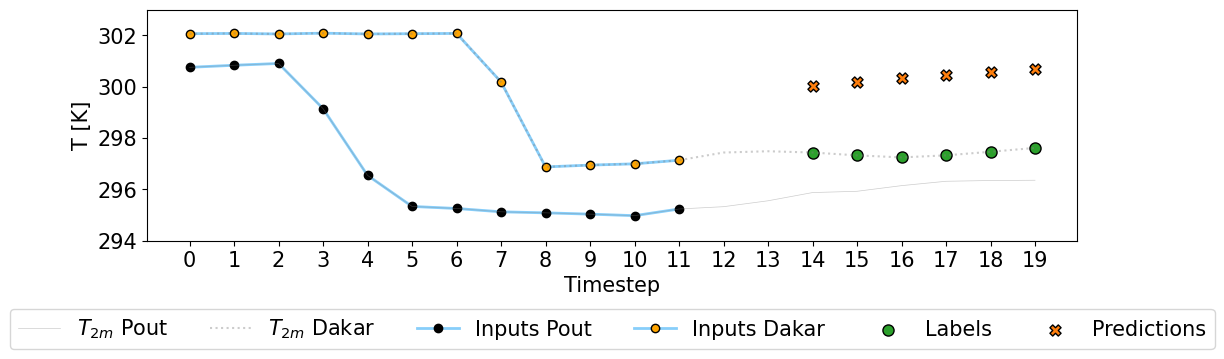

In [32]:
windows_real3.plot(ARlstm, plot_col_input='T2__Dakar', max_subplots=5, ylims=True, ymin=294, ymax=303)

In [41]:
'''
from IPython.display import clear_output
import time
import os
import shutil
import imageio

# Create a directory to store the images
output_dir = "animation_frames"
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir)

# Loop through each instance and save the plots as images
for i, window_instance in enumerate(window_instances):
    plt.figure(figsize=(10, 6))  # Adjust figsize as needed
    window_instance.plot(lstm, plot_col_input='T2__Dakar', max_subplots=5, ymin=293, ymax=304)
    plt.title(f'Window Instance {i+1}')
    plt.xlabel('X Label')
    plt.ylabel('Y Label')
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, f"plot_{i+1:03d}.png"))  # Save the plot as an image
    plt.close()
    clear_output(wait=True)
    print(f"Saved plot {i+1}")

# Create an animation from the saved images
images = []
for i in range(len(window_instances)):
    filename = os.path.join(output_dir, f"plot_{i+1:03d}.png")
    images.append(imageio.imread(filename))

# Save the animation
output_file = "animationlstm.gif"
imageio.mimsave(output_file, images, fps=3)  # Adjust the FPS as needed
print(f"Animation saved as {output_file}")
'''

'\nfrom IPython.display import clear_output\nimport time\nimport os\nimport shutil\nimport imageio\n\n# Create a directory to store the images\noutput_dir = "animation_frames"\nif os.path.exists(output_dir):\n    shutil.rmtree(output_dir)\nos.makedirs(output_dir)\n\n# Loop through each instance and save the plots as images\nfor i, window_instance in enumerate(window_instances):\n    plt.figure(figsize=(10, 6))  # Adjust figsize as needed\n    window_instance.plot(lstm, plot_col_input=\'T2__Dakar\', max_subplots=5, ymin=293, ymax=304)\n    plt.title(f\'Window Instance {i+1}\')\n    plt.xlabel(\'X Label\')\n    plt.ylabel(\'Y Label\')\n    plt.grid(True)\n    plt.savefig(os.path.join(output_dir, f"plot_{i+1:03d}.png"))  # Save the plot as an image\n    plt.close()\n    clear_output(wait=True)\n    print(f"Saved plot {i+1}")\n\n# Create an animation from the saved images\nimages = []\nfor i in range(len(window_instances)):\n    filename = os.path.join(output_dir, f"plot_{i+1:03d}.png")\n 

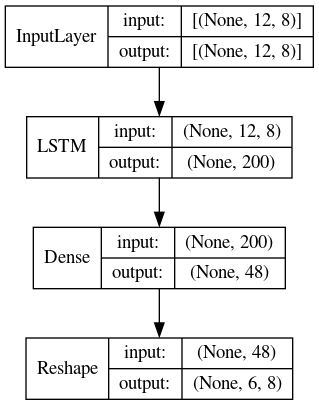

In [43]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import plot_model

# Define the number of time steps and features
time_steps = 10
features = 8

# Create the LSTM model
model = Sequential([
    LSTM(32, input_shape=(time_steps, features)),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Plot the model architecture
plot_model(lstm, show_shapes=True, show_layer_names=False)